# MLS Case Study - Recommendation Systems Part 1

---------------
## Context
---------------

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. For this case study, you can find the dataset [here](https://www.kaggle.com/rounakbanik/the-movies-dataset)

-----------------
## Objective
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

based on the **ratings** dataset

-----------------
## Dataset
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

We will also use the **movies** dataset to get the title of the movies. It contains the following attributes:
- movieId
- title
- genres

### Importing Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

### Loading the data

In [9]:
rating = pd.read_csv('ratings.csv')

Let's check the **info** of the data

In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [11]:
#Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

In [12]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### Exploring the dataset

Let's explore the dataset and answer some basic data-related questions:

#### Q1. What is the total number of unique users?

In [13]:
#Finding number of unique users
rating['userId'].nunique()

671

- There are **671 users** in the dataset

#### Q2. What is the total number of unique movies?

In [15]:
#Finding number of unique movies
rating['movieId'].nunique()

9066

- There are **9066 movies** in the dataset
- As per the number of unique users and movies, there is a **possibility of 671 * 9066 = 6,083,286 ratings** in the dataset. But **we only have 100,004 ratings**, i.e. not every user has rated every movie in the dataset. And we can build a recommendation system to recommend movies to users which they have not interacted with.

#### Q3. Is there any movie that has been interacted with more than once by the same user?

In [16]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [17]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of movies and a user**.

#### Q4. Which one is the most interacted movie in the dataset?

In [18]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

- The **movie with movieId: 356 has been interacted by most users** which is **341** times.
- But still, there is a possibility of 671-341 = 330 more interactions as we have 671 unique users in our datasets. For those 330 remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.

Also, out of these 341 interactions, we need to consider the distribution of ratings as well to check whether this movie is the most liked or most disliked movie.

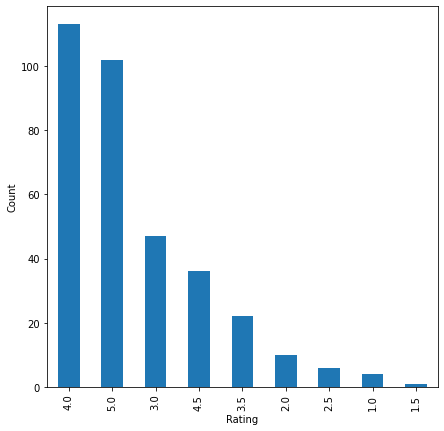

In [19]:
#Plotting distributions of ratings for 341 interactions with movieid 356 

plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

- We can see that **this movie has been liked by the majority of users**, as the count of ratings 5 and 4 is higher than the count of other ratings. 
- There can be movies with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the movie is disliked by the majority of users.

#### Q5. Which user interacted the most with any movie in the dataset?

In [20]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

- The user with **userId: 547** has interacted with the most number of movies i.e. **2391** times. 
- But still, there is a possibility of 9066-2391 = 6675 more interactions as we have 9066 unique movies in our dataset. For those **6675** remaining movies, we can build a recommendation system to predict which movies are most likely to be watched by this user.

#### Q6. What is the distribution of the user-movie interactions in this dataset?

In [21]:
#Finding user-movie interactions distribution

count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

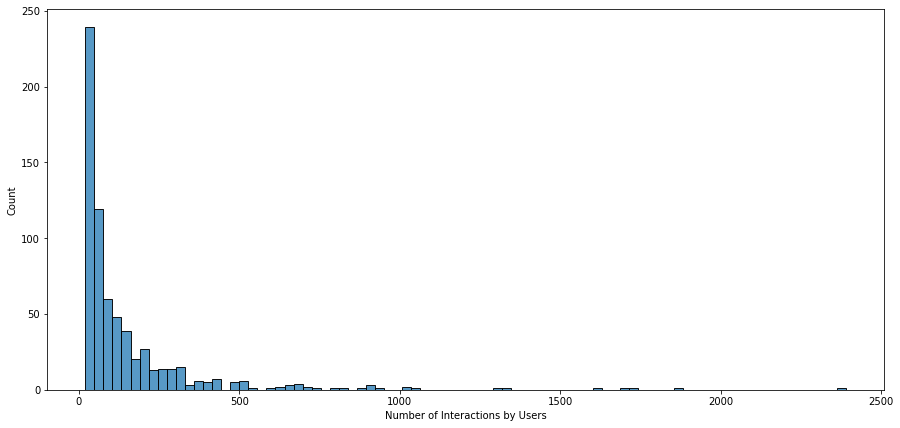

In [22]:
#Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

- The distribution is higher skewed to the right. Only a few users interacted with more than 50 movies. 

### Rank Based Recommendation System

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [23]:
#Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [24]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [25]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### Recommending top 5 movies with 50 minimum interactions based on popularity

In [26]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 913, 1221, 50]

#### Recommending top 5 movies with 100 minimum interactions based on popularity

In [27]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### Recommending top 5 movies with 200 minimum interactions based on popularity

In [28]:
list(top_n_movies(final_rating, 5, 200))

[318, 50, 527, 608, 296]

Now that we have seen how to apply the Rank-Based Recommendation System, let's apply Collaborative Filtering Based Recommendation System

### Collaborative Filtering Based Recommendation System

**First upload the images folder in Jupyter home**

![collaborative_filtering.PNG](collaborative_filtering.PNG)

In this above interactions matrix - out of the users B and C, which user is most likely to interact with the movie - The Terminal?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
- Model based

#### Building Similarity/Neighborhood based Collaborative Filtering

First, we compute the **user-item interactions matrix**

In [29]:
interactions_matrix = rating.pivot(index='userId', columns='movieId', values='rating')
interactions_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- This is a very **sparse matrix**. We will find out the most similar users using this matrix.

Below is one of the techniques to find out similar users. Here each user is denoted by a **vector of 9066 dimensions**. Then we will find out pairwise **cosine similarities** for all the users. If two vectors i.e. users are exactly same or lie on top each other, then they are most similar and cosine similarity will be 1

![cosine.PNG](cosine.PNG)

**Cosine similarity can't take missing values** in its vectors while computing, hence we need to fill those NaN values with zeros

In [30]:
interactions_matrix.fillna(0, inplace=True)
interactions_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's create a **function to find similar users and similarity scores for given userID and interaction matrix**

In [31]:
def similar_users(user_id, interactions_matrix):
    similarity = [] 
    for user in range(1, interactions_matrix.shape[0]+1):
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_id]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple 
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)   #Sorting the list on the basis of similarity scores
    
    most_similar_users = [tup[0] for tup in similarity] #Extracting the user from each tuple in the sorted list
    
    similarity_score = [tup[1] for tup in similarity]   #Extracting the similarity score from each tuple in the sorted list
    
    most_similar_users.remove(user_id)                  #Removing the original user and keeping only other similar users       
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

**We can use this function to find similar users for different user IDs**

#### Finding out top 10 similar users to the userID 2 and their similarity score

In [24]:
similar_users(2, interactions_matrix)[0][:10]

[338, 369, 151, 400, 385, 161, 649, 279, 144, 590]

- These are the top 10 users that are most similar to the user with userID 2

We can also find the level of similarity between similar users and the user with userID 2

In [25]:
similar_users(2, interactions_matrix)[1][:10]

[array([[0.58152829]]),
 array([[0.58074216]]),
 array([[0.57309653]]),
 array([[0.57125179]]),
 array([[0.56511317]]),
 array([[0.55807419]]),
 array([[0.55142965]]),
 array([[0.54787459]]),
 array([[0.53839727]]),
 array([[0.53793387]])]

Let's see one more example

#### Finding out top 10 similar users to the userID 667 and their similarity score

In [26]:
similar_users(667, interactions_matrix)[0][:10]

[385, 649, 36, 2, 161, 151, 86, 508, 121, 590]

In [27]:
similar_users(667, interactions_matrix)[1][:10]

[array([[0.4757166]]),
 array([[0.44589636]]),
 array([[0.43347883]]),
 array([[0.42546185]]),
 array([[0.42294725]]),
 array([[0.42072496]]),
 array([[0.41970381]]),
 array([[0.41156834]]),
 array([[0.40798078]]),
 array([[0.40262202]])]

**Note:** We can also put a threshold to the similarity score to build a more robust similar user identification. For example, if we choose a threshold of 0.5 similarity, then there are no users similar with userID 667. In that case, we can recommend the most popular movies to the user.

We have learned how to find similar users for a given user but how do we find which **movies to recommend to a particular user?** This is done by finding the **movies which have been interacted/rated the most by similar users** but not by the user of interest.

**Let's create a function to do the same.**

In [28]:
def recommendations(user_id, num_of_movies, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_id, interactions_matrix)[0]  
    
    #Finding movie IDs with which the user_id has interacted
    movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_id] > 0)]))
    recommendations = []
    
    observed_interactions = movie_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_movies:
            #Finding 'n' movies which have been rated by similar users but not by the user_id
            similar_user_movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_movie_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_movie_ids)
        else:
            break
    
    return recommendations[:num_of_movies]

Finally, we can recommend **`n`** number of movies to any user using the function defined above 

#### Recommend 5 movies to userID 2 based on similarity based collaborative filtering

In [29]:
recommendations(2, 5, interactions_matrix)

[2, 648, 141, 25, 282]

#### Recommend 5 movies to userID 667 based on similarity based collaborative filtering

In [30]:
recommendations(667, 5, interactions_matrix)

[256, 515, 261, 10, 527]

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![CF3.PNG](CF3.PNG)

Now if we notice the above movies closely:

![CF4.PNG](CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![CF5.PNG](CF5.PNG)

#### Singular Value Decomposition (SVD)

SVD is used to compute the latent features from the user-item matrix that we already learned earlier. But SVD does not work when we missing values in the user-item matrix.

First we need to convert the below movie-rating dataset:

![CF3.PNG](CF3.PNG)

into an user-item matrix as shown below:

![CF6.PNG](CF6.PNG)

We have already done this above while computing cosine similarities.

In [31]:
interactions_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### U-matrix

![CF7.PNG](CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### Sigma-matrix

![CF8.PNG](CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### V-transpose matrix

![CF9.PNG](CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

We can find the decomposition using the **`svd() function`** from the linalg module of the NumPy library.

In [32]:
u, s, vt = np.linalg.svd(interactions_matrix, full_matrices=False)

In [33]:
u.shape

(671, 671)

In [34]:
s.shape

(671,)

In [35]:
vt.shape

(671, 9066)

#### Splitting the dataset and selecting optimal latent variables

Now, we need to find the appropriate K to use in order to re-generate the interaction matrix and make predictions. We will split the data into **train and test data** and make predictions for different value of K. We will choose the K which gives good performance on the train and test data.

Now, let's split the data into **train and test data**

In [36]:
X_train, X_test = train_test_split(rating, test_size=0.2, random_state=42)

In [37]:
X_train.shape

(80003, 3)

In [38]:
X_test.shape

(20001, 3)

Let's create the **train and test interactions matrices**

In [39]:
#Train interaction matrix
interactions_matrix_train = X_train.pivot(index='userId', columns='movieId', values='rating')
interactions_matrix_train.fillna(0, inplace=True)

In [40]:
interactions_matrix_train.shape

(671, 8399)

In [41]:
#Test interaction matrix
interactions_matrix_test = X_test.pivot(index='userId', columns='movieId', values='rating')
interactions_matrix_test.fillna(0, inplace=True)

In [42]:
interactions_matrix_test.shape

(671, 4901)

We will use the **interactions_matrix_train** to find U, S, and V transpose using SVD. Then find the subset of rows in the **interactions_matrix_test** dataset which we can predict using this matrix decomposition with different numbers of latent features.

In [43]:
#Finding unique users in train and test data and then taking their intersection i.e. common users in train and test data 
train_idx = set(interactions_matrix_train.index)
test_idx = set(interactions_matrix_test.index)
match_idx = train_idx.intersection(test_idx)
    
#Finding unique movies in train and test data and then taking their intersection i.e. common movies in train and test data 
train_movies = set(interactions_matrix_train.columns)
test_movies = set(interactions_matrix_test.columns)
match_cols = train_movies.intersection(test_movies)

#Selecting only common users and movies from the test interaction matrix
interactions_matrix_test = interactions_matrix_test.loc[match_idx, match_cols]

In [44]:
interactions_matrix_test.shape

(671, 4234)

Now, let's decompose the **interactions_matrix_train** and **find the U and Vt for the test data** using the common users and movies in the train and test data

In [45]:
u_train, s_train, vt_train = np.linalg.svd(interactions_matrix_train, full_matrices=False)

In [46]:
#Finding u_test and vt_test matrices using u_train, vt_train and common user/movies in train and test data
row_idxs = interactions_matrix_train.index.isin(test_idx)
col_idxs = interactions_matrix_train.columns.isin(test_movies)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

We have calculated U and Vt matrices for the train as well as test data. Now, we need to find the number of latent features that give us the **lowest RMSE on the train and the test data**.

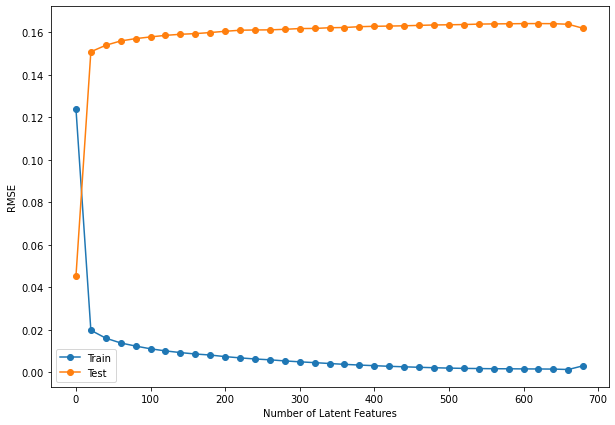

In [47]:
#Creating array for number of latent features and empty lists to store train and test errors
latent_features = np.arange(0, 700, 20) 
train_error = []
test_error = []

for k in latent_features:
    #Slicing the U, S, and Vt matrices to get k latent features from train and test data 
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    #Regenerating train and test interaction matrices using k latent features
    interactions_matrix_train_preds = np.around(np.matmul(np.matmul(u_train_lat, s_train_lat), vt_train_lat))
    interactions_matrix_test_preds = np.around(np.matmul(np.matmul(u_test_lat, s_train_lat), vt_test_lat))
    
    #Calculating the actual and predicted average rating for each movie in the training data
    avg_rating_train = interactions_matrix_train.mean(axis=0)
    avg_rating_train_pred = interactions_matrix_train_preds.mean(axis=0)
    
    #Calculating the actual and predicted average rating for each movie in the test data
    avg_rating_test = interactions_matrix_test.mean(axis=0)
    avg_rating_test_pred = interactions_matrix_test_preds.mean(axis=0)
    
    #Calculating train and test RMSE
    train_rmse = mean_squared_error(avg_rating_train, avg_rating_train_pred, squared=False)
    test_rmse = mean_squared_error(avg_rating_test, avg_rating_test_pred, squared=False)
    
    train_error.append(train_rmse)
    test_error.append(test_rmse)
    
#Plotting train and test RMSE
plt.figure(figsize=(10,7))
plt.plot(latent_features, train_error, label='Train', marker='o');
plt.plot(latent_features, test_error, label='Test', marker='o');
plt.xlabel('Number of Latent Features');
plt.ylabel('RMSE');
plt.legend();

From the above plot we can see that we got a **reasonable RMSE in both train and test dataset at around latent features=10.** If we increase the latent features it will be overfitted and decreasing the latent features will underfit the model.

Let us now **reconstruct the original interaction matrix using latent features = 10** in the same way as above

In [48]:
s_final, u_final, vt_final = np.diag(s[:10]), u[:, :10], vt[:10, :]
movies_predicted_ratings = np.around(np.matmul(np.matmul(u_final, s_final), vt_final))
movies_predicted_ratings = pd.DataFrame(abs(movies_predicted_ratings), columns = interactions_matrix.columns, index = interactions_matrix.index)
movies_predicted_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have the predictions of ratings but we need to create a **function to recommend movies** to the users on the basis of predicted ratings for each movie

In [49]:
# Recommend the movies with the highest predicted ratings

def recommend_movies(user_idx, interactions_matrix, preds_df, num_recommendations):
          
    # Get and sort the user's ratings from the actual and predicted interaction matrix
    sorted_user_ratings = interactions_matrix.loc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_idx].sort_values(ascending=False)
    
    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Movies'
    temp.columns = ['user_ratings', 'user_predictions']
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that movie
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending movies with top predicted ratings
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended movies for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

Now, let's use the function defined above to **recommend movies to a user**

In [50]:
user_index = 121
num_recommendations = 5
recommend_movies(user_index, interactions_matrix, movies_predicted_ratings, num_recommendations)


Below are the recommended movies for user(user_id = 121):

Recommended Movies
292    3.0
500    3.0
344    3.0
47     3.0
2      2.0
Name: user_predictions, dtype: float64


We can also find the **name of the recommended movies** from the movie ID using the **movies.csv dataset**.

In [51]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [52]:
#merging rating and movies datasets to get title of movies
merged_data = pd.merge(rating, movies[['movieId', 'title']], on='movieId' )
    
#Getting movie names from the recommended movie IDs
movie_names = merged_data.loc[[292, 500, 344, 47, 2]]['title'].unique()
list(movie_names)

['Ben-Hur (1959)',
 'Beavis and Butt-Head Do America (1996)',
 'Gandhi (1982)',
 'Dumbo (1941)',
 'Dangerous Minds (1995)']

Finally, we can **calculate the RMSE** for the final ratings predicted using the model-based recommendation system. 

In [53]:
#creating a dataframe containing average actual ratings and avearge predicted ratings of the movies
rmse_df = pd.concat([interactions_matrix.mean(), movies_predicted_ratings.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
rmse_df

,Avg_actual_ratings,Avg_predicted_ratings
movieId,,
1,1.425484,1.321908
2,0.542474,0.542474
3,0.277943,0.156483
4,0.046200,0.000000
5,0.272727,0.180328
...,...,...
161944,0.007452,0.000000
162376,0.006706,0.005961
162542,0.007452,0.000000


In [54]:
RMSE = mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.021673725648833228 



- The **RMSE is low** which implies that the majority of **predicted ratings are close to the actual ratings**.

### Conclusions

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.